# Multitask GP Regression

In [86]:
import numpy as np
import pandas as pd
import math
import torch
import gpytorch as gpt
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up training data

In [88]:
meuse_df = pd.read_csv("../data/meuse.csv")
print(meuse_df.shape)
targets = ["cadmium", "copper", "lead", "zinc"]
features = ["dist", "x", "y"]

meuse_df[targets] = meuse_df[targets] / meuse_df[targets].mean() # Normalise data

(155, 14)


In [72]:
train, test = np.split(meuse_df.sample(frac=1, random_state=42), 
                       [int(.7*len(meuse_df))])
train_x = torch.tensor(train[features].values, dtype=torch.float)
train_y = torch.tensor(train[targets].values, dtype=torch.float)
test_x = torch.tensor(test[features].values, dtype=torch.float)
test_y = torch.tensor(test[targets].values, dtype=torch.float)
train_x.shape, train_y.shape, test_x.shape

(torch.Size([108, 3]), torch.Size([108, 4]), torch.Size([47, 3]))

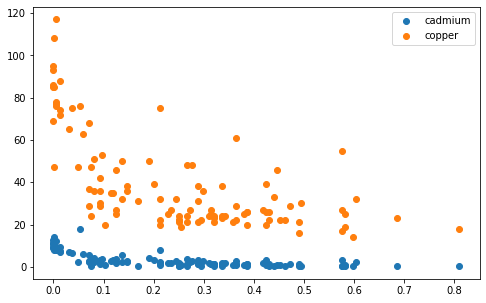

In [73]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(train_x.numpy()[:,0], train_y.numpy()[:,0])
ax.scatter(train_x.numpy()[:,0], train_y.numpy()[:,1])
plt.legend(["cadmium", "copper"]);

### Define a multitask model

In [74]:
class MultitaskGPModel(gpt.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpt.means.MultitaskMean(
            gpt.means.ConstantMean(), num_tasks=4
        )
        self.covar_module = gpt.kernels.MultitaskKernel(
            gpt.kernels.RBFKernel(), num_tasks=4, rank=1
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpt.distributions.MultitaskMultivariateNormal(mean_x, covar_x)
    
likelihood = gpt.likelihoods.MultitaskGaussianLikelihood(num_tasks=4)
model = MultitaskGPModel(train_x, train_y, likelihood)

### Train the model

In [75]:
training_iters = 50

model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
# Loss for the marginal log likelihood
mll = gpt.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, torch.reshape(train_y, (-1,)))
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iters, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 16928.275
Iter 2/50 - Loss: 15430.546
Iter 3/50 - Loss: 14039.879
Iter 4/50 - Loss: 12750.594
Iter 5/50 - Loss: 11562.048
Iter 6/50 - Loss: 10472.750
Iter 7/50 - Loss: 9478.232
Iter 8/50 - Loss: 8573.682
Iter 9/50 - Loss: 7755.756
Iter 10/50 - Loss: 7020.412
Iter 11/50 - Loss: 6361.958
Iter 12/50 - Loss: 5774.500
Iter 13/50 - Loss: 5252.925
Iter 14/50 - Loss: 4792.001
Iter 15/50 - Loss: 4385.812
Iter 16/50 - Loss: 4028.417
Iter 17/50 - Loss: 3714.607
Iter 18/50 - Loss: 3439.678
Iter 19/50 - Loss: 3199.005
Iter 20/50 - Loss: 2988.117
Iter 21/50 - Loss: 2803.069
Iter 22/50 - Loss: 2640.537
Iter 23/50 - Loss: 2497.604
Iter 24/50 - Loss: 2371.575
Iter 25/50 - Loss: 2260.015
Iter 26/50 - Loss: 2160.864
Iter 27/50 - Loss: 2072.436
Iter 28/50 - Loss: 1993.293
Iter 29/50 - Loss: 1922.157
Iter 30/50 - Loss: 1857.889
Iter 31/50 - Loss: 1799.529
Iter 32/50 - Loss: 1746.302
Iter 33/50 - Loss: 1697.571
Iter 34/50 - Loss: 1652.779
Iter 35/50 - Loss: 1611.429
Iter 36/50 - Loss: 1573

### Make predictions with the model

In [81]:
# Set into eval mode
model.eval()
likelihood.eval()

# Make predictions
with torch.no_grad(), gpt.settings.fast_pred_var():
    predictions = likelihood(model(train_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

/home/danph/Repos/win_ssd/oss/gp_experiments/.venv/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [77]:
mean.shape, test_x.shape, lower.shape, upper.shape

(torch.Size([47, 4]),
 torch.Size([47, 3]),
 torch.Size([47, 4]),
 torch.Size([47, 4]))

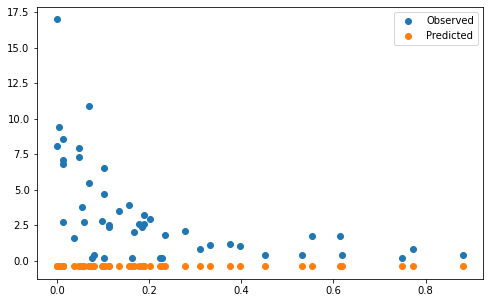

In [80]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(test_x.numpy()[:,0], test_y.numpy()[:,0])
ax.scatter(test_x.numpy()[:,0], mean.numpy()[:,0])
# ax.fill_between(test_x.numpy()[:,0], lower.numpy()[:, 0], upper.numpy()[:, 0], alpha=0.3)

plt.legend(["Observed", "Predicted"])

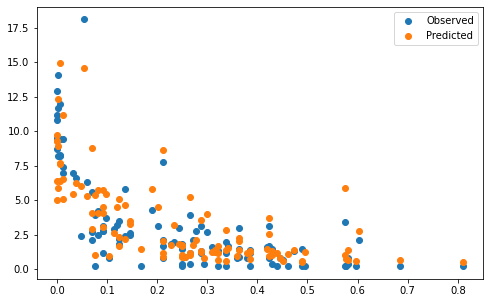

In [85]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax.scatter(train_x.numpy()[:,0], train_y.numpy()[:,0])
ax.scatter(train_x.numpy()[:,0], mean.numpy()[:,0])
# ax.fill_between(train_x.numpy()[:,0], lower.numpy()[:, 0], upper.numpy()[:, 0], alpha=0.2)

plt.legend(["Observed", "Predicted"])

References: 
- https://docs.gpytorch.ai/en/latest/examples/03_Multitask_Exact_GPs/Multitask_GP_Regression.html